# Data Fetching and train-test split

## Import libraries and data

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
# pip install -q -U keras-tuner

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance
# import pydot
# import graphviz
import matplotlib.pyplot as plt
# import pathlib
# from os import getcwd

Training data is taken from Quora Questions Pairs dataset (training set only) https://www.kaggle.com/c/quora-question-pairs/overview translated to Indonesian with Google Translate

In [2]:
data1=pd.read_csv("D:/Documents/GitHub/bangkit-capstone0143/train complete indo.csv")

In [3]:
data1.shape

(404290, 6)

In [88]:
pd.value_counts(data1['is_duplicate'])

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [86]:
is_NaN = data1.isnull()

row_has_NaN = is_NaN.any(axis=1)

rows_with_NaN = data1[row_has_NaN]
print(rows_with_NaN)

            id    qid1    qid2  \
105780  105780  174363  174364   
201841  201841  303951  174364   

                                             question1 question2  is_duplicate  
105780  Bagaimana cara mengembangkan aplikasi Android?       NaN             0  
201841        Bagaimana cara membuat aplikasi Android?       NaN             0  


In [3]:
data1=data1.dropna()

In [43]:
data1.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,Apa panduan langkah demi langkah untuk berinve...,Apa panduan langkah demi langkah untuk berinve...,0
1,1,3,4,Bagaimana kisah Berlian Kohinoor (Koh-i-Noor)?,Apa yang akan terjadi jika pemerintah India me...,0
2,2,5,6,Bagaimana cara meningkatkan kecepatan koneksi ...,Bagaimana kecepatan Internet dapat ditingkatka...,0
3,3,7,8,Mengapa saya secara mental sangat kesepian? Ba...,Temukan sisanya ketika [math] 23 ^ {24} [/ mat...,0
4,4,9,10,Manakah yang larut dalam air seperti gula pasi...,Ikan apa yang akan bertahan hidup di air asin?,0


<AxesSubplot:>

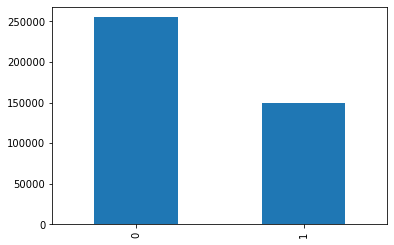

In [84]:
pd.value_counts(data1['is_duplicate']).plot.bar()

In [21]:
data1.question1.str.len().max()

717

In [22]:
data1.question2.str.len().max()

1395

## Train,val,test split 80% 10% 10%

In [4]:
# The validation will be split later in the model training and hyperparameter tuning
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1[["question1", "question2"]], data1["is_duplicate"], test_size=0.1, random_state=42)

Transform the dataframe to NumPy array as TensorFlow takes NumPy arrays

In [5]:
xt=X_train.to_numpy()
yt=y_train.to_numpy()

xte=X_test.to_numpy()
yte=y_test.to_numpy()

Q1_train = X_train["question1"].to_numpy()
Q2_train = X_train["question2"].to_numpy()
Q1_test = X_test["question1"].to_numpy()
Q2_test = X_test["question2"].to_numpy()

In [8]:
xt.shape

(363859, 2)

In [7]:
xte.shape

(40429, 2)

In [25]:
Q1_train

array(['Apa sajakah proyek teknik mesin?',
       'Bagaimana Anda tahu jika dia tertarik pada Anda?',
       'Bisakah kita menemukan ketinggian ponsel dari tanah secara akurat.?\xa0â € ¦Jika tidak, bagaimana bisa mengatasinya.?',
       ..., 'Siapa yang saat ini memenangkan pemilihan presiden?',
       'Apa sajakah film Telugu / Tamil / Hindi yang pemeran utamanya menjadi mafia atau tidak?',
       'Berapa peringkat yang dipotong untuk perguruan tinggi Kedokteran Rohtak dalam kuota negara bagian?'],
      dtype=object)

In [26]:
data1["question1"][0]

'Apa panduan langkah demi langkah untuk berinvestasi di pasar saham di India?'

In [27]:
data1[["question1","question2"]]

,question1,question2
0,Apa panduan langkah demi langkah untuk berinve...,Apa panduan langkah demi langkah untuk berinve...
1,Bagaimana kisah Berlian Kohinoor (Koh-i-Noor)?,Apa yang akan terjadi jika pemerintah India me...
2,Bagaimana cara meningkatkan kecepatan koneksi ...,Bagaimana kecepatan Internet dapat ditingkatka...
3,Mengapa saya secara mental sangat kesepian? Ba...,Temukan sisanya ketika [math] 23 ^ {24} [/ mat...
4,Manakah yang larut dalam air seperti gula pasi...,Ikan apa yang akan bertahan hidup di air asin?
...,...,...
404285,Ada berapa kata kunci dalam bahasa pemrograman...,Ada berapa kata kunci dalam Bahasa Pemrograman...
404286,Apakah Anda percaya ada kehidupan setelah kema...,Benarkah ada kehidupan setelah kematian?
404287,Apa satu koin?,Koin apa ini?
404288,Berapa perkiraan biaya hidup tahunan selama be...,Saya mengalami sedikit masalah rambut rontok t...


## Embbeding layer

Fetching from local directory

In [6]:
embed=hub.KerasLayer(hub.load("C:/Users/stanl/Downloads/nnlm-id-dim128-norm"), input_shape=[], dtype=tf.string)

Fetching directly from the tfhub (requires internet) about 430 MB in size

In [ ]:
# Model runtime will increase if tranable=True to about 900-1000s per epoch
# embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2",input_shape=[], dtype=tf.string)
# embed.trainable=True

## Cosine Similarity test

In [8]:
xt1=embed(Q1_train)
xt2=embed(Q2_train)
xte1=embed(Q1_test)
xte2=embed(Q2_test)

In [31]:
# xt2

<tf.Tensor: shape=(363859, 128), dtype=float32, numpy=
array([[-0.053753  , -0.09628158, -0.06266727, ..., -0.03710537,
        -0.10238572,  0.02226824],
       [ 0.14299224,  0.18877506, -0.03349154, ..., -0.00806341,
        -0.07145633,  0.1015135 ],
       [ 0.05941568, -0.1906344 ,  0.18621024, ..., -0.088122  ,
        -0.22306792,  0.13632292],
       ...,
       [ 0.23911878, -0.14783452,  0.0107425 , ..., -0.0815316 ,
        -0.24931498,  0.05062477],
       [ 0.0373978 ,  0.03045387,  0.01306245, ..., -0.16649947,
        -0.04637462, -0.02678967],
       [ 0.01217015, -0.02358004,  0.0645157 , ..., -0.1297544 ,
        -0.13054067,  0.18736517]], dtype=float32)>

In [32]:
# xt1

<tf.Tensor: shape=(363859, 128), dtype=float32, numpy=
array([[ 1.90162417e-02, -1.18593588e-01, -9.78335068e-02, ...,
         2.17009820e-02, -1.48417562e-01,  1.14940396e-02],
       [ 2.64445841e-01,  1.02562383e-01, -8.19351301e-02, ...,
         1.63417123e-02, -1.40222088e-01,  1.21525474e-01],
       [ 1.03515968e-01, -8.21223408e-02, -6.16349280e-06, ...,
        -2.67180860e-01, -1.27561107e-01,  1.11764565e-01],
       ...,
       [ 1.74064666e-01,  6.94696233e-02, -2.17809826e-02, ...,
        -5.72771169e-02, -1.78512469e-01, -6.91926526e-03],
       [ 1.42883718e-01, -1.64006665e-01,  3.34761925e-02, ...,
         4.38854322e-02, -1.28632009e-01, -2.39136852e-02],
       [-2.10693181e-02, -2.26702049e-01, -1.17028758e-01, ...,
        -1.37420133e-01, -1.14242919e-01,  8.96925703e-02]], dtype=float32)>

In [9]:
cos_sim_train=[]
cos_sim_test=[]
for i in range(len(xt1)):
    cos_sim_train.append(1-distance.cosine(xt1[i],xt2[i]))
for i in range(len(xte1)):
    cos_sim_test.append(1-distance.cosine(xte1[i],xte2[i]))

In [3]:
test1=embed(["kucing dan anjing"])
test2=embed(["anjing dan kucing"])
test3=embed(["dan anjing kucing"])

In [9]:
test11=embed(["kucing anjing"])
test12=embed(["kucing"])
test13=embed(["anjing"])

In [10]:
test11

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.16812997, -0.00759348,  0.03780371, -0.03595867, -0.06934683,
        -0.00539866, -0.05020032, -0.12159169,  0.16381314, -0.05194341,
         0.10913703, -0.04081987,  0.20021515, -0.06177137, -0.09899464,
        -0.08970435,  0.04053309,  0.02928063,  0.11936226, -0.12293857,
         0.24125458,  0.02006513, -0.07871483,  0.04063652,  0.16337541,
         0.03929602, -0.06251655,  0.18665291,  0.17572622,  0.18225703,
        -0.06205942, -0.11025415,  0.07715053, -0.06593005,  0.13781665,
        -0.12974054, -0.02315177, -0.07283551,  0.02718993,  0.09988234,
         0.20807368,  0.01524868,  0.02729617, -0.0334528 ,  0.03376943,
        -0.18161568,  0.2750006 , -0.19823752,  0.08614155,  0.09140126,
        -0.07361856, -0.06692415, -0.21191208,  0.20213038, -0.13844648,
         0.13312642,  0.08642519,  0.10245437, -0.11232141,  0.04668635,
        -0.0180586 ,  0.34764612,  0.01714458,  0.03252869, -0.126979  ,
 

In [15]:
(test12+test13)/np.sqrt([2])[0]

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.16812998, -0.00759348,  0.03780371, -0.03595867, -0.06934684,
        -0.00539866, -0.05020033, -0.1215917 ,  0.16381314, -0.05194341,
         0.10913704, -0.04081988,  0.20021515, -0.06177137, -0.09899464,
        -0.08970435,  0.0405331 ,  0.02928063,  0.11936227, -0.12293857,
         0.2412546 ,  0.02006513, -0.07871483,  0.04063652,  0.16337541,
         0.03929602, -0.06251655,  0.18665293,  0.17572623,  0.18225703,
        -0.06205942, -0.11025415,  0.07715053, -0.06593006,  0.13781665,
        -0.12974054, -0.02315177, -0.07283551,  0.02718993,  0.09988234,
         0.20807369,  0.01524868,  0.02729617, -0.0334528 ,  0.03376943,
        -0.18161568,  0.2750006 , -0.19823754,  0.08614156,  0.09140126,
        -0.07361857, -0.06692416, -0.21191208,  0.20213039, -0.13844648,
         0.13312642,  0.08642519,  0.10245437, -0.11232141,  0.04668635,
        -0.01805861,  0.34764615,  0.01714458,  0.03252869, -0.126979  ,
 

In [10]:
cos_sim_train_round=[1 if x>=0 else 0 for x in cos_sim_train]
cos_sim_test_round=[1 if x>=0 else 0 for x in cos_sim_test]

In [63]:
# confusion_matrix(yt,cos_sim_train_round)

array([[  1091, 228546],
       [     9, 134213]], dtype=int64)

In [64]:
# confusion_matrix(yte,cos_sim_test_round)

array([[  116, 25272],
       [    0, 15041]], dtype=int64)

In [13]:
(confusion_matrix(yte,cos_sim_test_round)[0,0]+confusion_matrix(yte,cos_sim_test_round)[1,1])/len(yte)

0.37490415295950924

# Final Models
## Models with two inputs and embedding integrated

Stacking RNNs did not yield significant result, hence we only use one layer of Bidirectional RNN

## Model with 1 dense layer

In [29]:
# Model with Bidirectional LSTM, GRU, without Attention, will run for about 150-200s per epoch
def model_builder_bilstm(hp):
  hp_units_L1 = hp.Choice('units_L1',values=[32, 64, 128], default=64)
  hp_units1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
  hp_rate1 = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.2,step=0.05)

  qstn1=tf.keras.Input(shape=(), dtype=tf.string)
  qstn2=tf.keras.Input(shape=(), dtype=tf.string)

  qu1=embed(qstn1)
  qu2=embed(qstn2)
  concat=tf.keras.layers.concatenate([qu1,qu2])
  concat=tf.keras.layers.Reshape((2,128))(concat)
  concat=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hp_units_L1))(concat)
  concat=tf.keras.layers.Dense(units=hp_units1,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate1)(concat)
  is_dupe=tf.keras.layers.Dense(1, activation="sigmoid")(concat)

  model = tf.keras.models.Model(inputs=[qstn1,qstn2], outputs=is_dupe)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [7]:
def model_builder_bigru(hp):
  hp_units_L1 = hp.Choice('units_L1',values=[32, 64, 128], default=64)
  hp_units1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
  hp_rate1 = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.2,step=0.05)

  qstn1=tf.keras.Input(shape=(), dtype=tf.string)
  qstn2=tf.keras.Input(shape=(), dtype=tf.string)

  qu1=embed(qstn1)
  qu2=embed(qstn2)
  concat=tf.keras.layers.concatenate([qu1,qu2])
  concat=tf.keras.layers.Reshape((2,128))(concat)
  concat=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=hp_units_L1))(concat)
  concat=tf.keras.layers.Dense(units=hp_units1,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate1)(concat)
  is_dupe=tf.keras.layers.Dense(1, activation="sigmoid")(concat)

  model = tf.keras.models.Model(inputs=[qstn1,qstn2], outputs=is_dupe)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

## Model with 2 dense layers

In [9]:
# Model with Bidirectional LSTM, GRU, without Attention, will run for about 150-200s per epoch
def model_builder_bilstm_2(hp):
  hp_units_L1 = hp.Choice('units_L1',values=[32, 64, 128], default=64)
  hp_units1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
  hp_rate1 = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.2,step=0.05)
  hp_rate2 = hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.2,step=0.05)

  qstn1=tf.keras.Input(shape=(), dtype=tf.string)
  qstn2=tf.keras.Input(shape=(), dtype=tf.string)

  qu1=embed(qstn1)
  qu2=embed(qstn2)
  concat=tf.keras.layers.concatenate([qu1,qu2])
  concat=tf.keras.layers.Reshape((2,128))(concat)
  concat=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hp_units_L1))(concat)
  concat=tf.keras.layers.Dense(units=hp_units1,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate1)(concat)
  concat=tf.keras.layers.Dense(units=hp_units2,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate2)(concat)
  is_dupe=tf.keras.layers.Dense(1, activation="sigmoid")(concat)

  model = tf.keras.models.Model(inputs=[qstn1,qstn2], outputs=is_dupe)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [7]:
def model_builder_bigru_2(hp):
  hp_units_L1 = hp.Choice('units_L1',values=[32, 64, 128], default=64)
  hp_units1 = hp.Int('units_1', min_value=64, max_value=512, step=32)
  hp_units2 = hp.Int('units_2', min_value=64, max_value=512, step=32)
  hp_rate1 = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.2,step=0.05)
  hp_rate2 = hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.2,step=0.05)
  qstn1=tf.keras.Input(shape=(), dtype=tf.string)
  qstn2=tf.keras.Input(shape=(), dtype=tf.string)

  qu1=embed(qstn1)
  qu2=embed(qstn2)
  concat=tf.keras.layers.concatenate([qu1,qu2])
  concat=tf.keras.layers.Reshape((2,128))(concat)
  concat=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=hp_units_L1))(concat)
  concat=tf.keras.layers.Dense(units=hp_units1,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate1)(concat)
  concat=tf.keras.layers.Dense(units=hp_units2,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate2)(concat)
  is_dupe=tf.keras.layers.Dense(1, activation="sigmoid")(concat)

  model = tf.keras.models.Model(inputs=[qstn1,qstn2], outputs=is_dupe)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

## Model small testing

See if the models work

In [27]:
qstn1=tf.keras.Input(shape=(), dtype=tf.string)
qstn2=tf.keras.Input(shape=(), dtype=tf.string)

qu1=embed(qstn1)
qu2=embed(qstn2)
concat=tf.keras.layers.concatenate([qu1,qu2])
concat=tf.keras.layers.Reshape((2,128))(concat)
concat=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=128))(concat)
concat=tf.keras.layers.Dense(units=32,activation='relu')(concat)
concat=tf.keras.layers.Dropout(rate=0.2)(concat)
is_dupe=tf.keras.layers.Dense(1, activation="sigmoid")(concat)

model_bigru = tf.keras.models.Model(inputs=[qstn1,qstn2], outputs=is_dupe)
model_bigru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bigru.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 256)          0           keras_layer[56][0]    

In [28]:
history_bigru = model_bigru.fit([Q1_train, Q2_train], yt, epochs=5, validation_split=0.1)

Epoch 1/5
10234/10234 [==============================] - 50s 5ms/step - loss: 0.5263 - accuracy: 0.7257 - val_loss: 0.4849 - val_accuracy: 0.7553
Epoch 2/5
10234/10234 [==============================] - 58s 6ms/step - loss: 0.4672 - accuracy: 0.7648 - val_loss: 0.4610 - val_accuracy: 0.7704
Epoch 3/5
10234/10234 [==============================] - 58s 6ms/step - loss: 0.4412 - accuracy: 0.7812 - val_loss: 0.4462 - val_accuracy: 0.7780
Epoch 4/5
10234/10234 [==============================] - 53s 5ms/step - loss: 0.4213 - accuracy: 0.7934 - val_loss: 0.4358 - val_accuracy: 0.7854
Epoch 5/5
10234/10234 [==============================] - 56s 5ms/step - loss: 0.4043 - accuracy: 0.8042 - val_loss: 0.4325 - val_accuracy: 0.7899


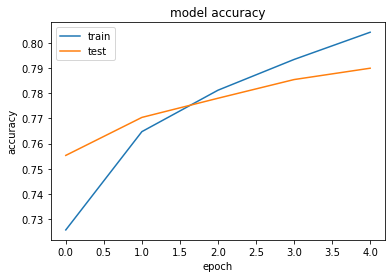

In [31]:
plt.plot(history_bigru.history['accuracy'])
plt.plot(history_bigru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
eval_result = model_bigru.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 1ms/step - loss: 0.4306 - accuracy: 0.7917
[test loss, test accuracy]: [0.43060511350631714, 0.7916842103004456]


In [30]:
eval_result = model_bigru.evaluate([Q2_test,Q1_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 1ms/step - loss: 0.4467 - accuracy: 0.7806
[test loss, test accuracy]: [0.4467344582080841, 0.7805535793304443]


# Hyperparameter Tuning

Hyperband is used as the tuning algorithm and early stopping is used to prevent overfitting and make the tuning quicker

The tuning would take about 2-3 hours (this was done with Ryzen 7 5700H and NVIDIA RTX 3060 Laptop GPU) per model, it may takes longer or shorter depending on the hardware used. Using Google Colab is not recommended as it will crash or disconnect due to limited GPU usage before the tuning of one model is finished. It might be still feasible using scheduling or multiple emails.

The model's size is about 1 GB each and the checkpoints folder is about 13 GB each

In [33]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True)

### Model with 1 dense layer

In [30]:
tuner_bilstm = kt.Hyperband(model_builder_bilstm,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='D:/NLP Model/keras_tuner_checkpoints_4',
                     overwrite=False,
                     project_name='model_bilstm')

In [9]:
tuner_bigru = kt.Hyperband(model_builder_bigru,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='D:/NLP Model/keras_tuner_checkpoints_4',
                     overwrite=False,
                     project_name='model_bigru')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Model with 2 dense layers

In [14]:
tuner_bilstm_2 = kt.Hyperband(model_builder_bilstm_2,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='D:/NLP Model/keras_tuner_checkpoints_3',
                     overwrite=False,
                     project_name='model_bilstm_2')

INFO:tensorflow:Reloading Oracle from existing project D:/NLP Model/keras_tuner_checkpoints_3\model_bilstm_2\oracle.json
INFO:tensorflow:Reloading Tuner from D:/NLP Model/keras_tuner_checkpoints_3\model_bilstm_2\tuner0.json


In [9]:
tuner_bigru_2 = kt.Hyperband(model_builder_bigru_2,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='D:/NLP Model/keras_tuner_checkpoints_3',
                     overwrite=False,
                     project_name='model_bigru_2')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Hyperparameter Result

### Model with 1 dense layer

In [34]:
tuner_bilstm.search([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_bilstm=tuner_bilstm.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units RNN layer is {best_hps_bilstm.get("units_L1")}, 
in the densely-connected
layer is {best_hps_bilstm.get('units_1')}, and the optimal droupout rate for the optimizer
is {best_hps_bilstm.get('dropout_1')}.
""")

Trial 32 Complete [00h 08m 39s]
val_accuracy: 0.8088550567626953

Best val_accuracy So Far: 0.8093222379684448
Total elapsed time: 01h 53m 55s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units RNN is 128, 
in the densely-connected
layers is 256 and the optimal droupout rate
is 0.45.



In [10]:
tuner_bigru.search([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_bigru=tuner_bigru.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the RNN layer is {best_hps_bigru.get("units_L1")}, in the densely-connected
layer is {best_hps_bigru.get('units_1')}, and the optimal droupout rate for the optimizer
is {best_hps_bigru.get('dropout_1')}.
""")

Trial 30 Complete [00h 03m 01s]
val_accuracy: 0.7812620401382446

Best val_accuracy So Far: 0.8091298937797546
Total elapsed time: 01h 37m 05s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the RNN layer is 128, in the densely-connected
layer is 320, and the optimal droupout rate for the optimizer
is 0.45.



### Model with 2 dense layers

In [15]:
tuner_bilstm_2.search([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_bilstm_2=tuner_bilstm_2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the RNN layer is {best_hps_bilstm_2.get('units_L1')}, the densely-connected
layers are {best_hps_bilstm_2.get('units_1')}, {best_hps_bilstm_2.get('units_2')}, and the optimal droupout rate for the optimizer
is {best_hps_bilstm_2.get('dropout_1')}, {best_hps_bilstm_2.get('dropout_2')}.
""")

Trial 17 Complete [00h 04m 41s]
val_accuracy: 0.7932721376419067

Best val_accuracy So Far: 0.8106414675712585
Total elapsed time: 01h 48m 40s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the RNN layer is 128, the densely-connected
layers are 352, 256, and the optimal droupout rate for the optimizer
is 0.30000000000000004, 0.1.



In [10]:
tuner_bigru_2.search([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_bigru_2=tuner_bigru_2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the RNN layer is 
{best_hps_bigru_2.get('units_L1')}, the densely-connected
layers are {best_hps_bigru_2.get('units_1')}, {best_hps_bigru_2.get('units_2')}, and the optimal droupout rate for the optimizer
is {best_hps_bigru_2.get('dropout_1')}, {best_hps_bigru_2.get('dropout_2')}.
""")

Trial 30 Complete [00h 05m 48s]
val_accuracy: 0.7869784832000732

Best val_accuracy So Far: 0.8093772530555725
Total elapsed time: 01h 56m 20s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the RNN layer is 
128, the densely-connected
layers are 320, 480, and the optimal droupout rate for the optimizer
is 0.2, 0.25.



## Models after tuned

### Model with 1 dense layer

In [35]:
best_model_bilstm = tuner_bilstm.get_best_models()[0]
best_model_bilstm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[128][0]   

In [11]:
best_model_bigru = tuner_bigru.get_best_models()[0]
best_model_bigru.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[62][0]    

### Model with 2 dense layer

In [16]:
best_model_bilstm_2 = tuner_bilstm_2.get_best_models()[0]
best_model_bilstm_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[66][0]    

In [11]:
best_model_bigru_2 = tuner_bigru_2.get_best_models()[0]
best_model_bigru_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[62][0]    

# Evaluation

## Test set evaluation

### Model with 1 dense layer

In [36]:
eval_result = best_model_bilstm.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.4397 - accuracy: 0.8086
[test loss, test accuracy]: [0.4396616816520691, 0.8086274862289429]


In [37]:
eval_result = best_model_bilstm.evaluate([Q2_test,Q1_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.4712 - accuracy: 0.7935
[test loss, test accuracy]: [0.47118642926216125, 0.7935145497322083]


In [12]:
eval_result = best_model_bigru.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 2ms/step - loss: 0.4236 - accuracy: 0.8091
[test loss, test accuracy]: [0.423641175031662, 0.8091221451759338]


In [13]:
eval_result = best_model_bigru.evaluate([Q2_test,Q1_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 2ms/step - loss: 0.4547 - accuracy: 0.7949
[test loss, test accuracy]: [0.4546811580657959, 0.7949244379997253]


### Model with 2 dense layers

In [17]:
eval_result = best_model_bilstm_2.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.4115 - accuracy: 0.8087
[test loss, test accuracy]: [0.4115205705165863, 0.80872642993927]


In [12]:
eval_result = best_model_bigru_2.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.4155 - accuracy: 0.8101
[test loss, test accuracy]: [0.4155394732952118, 0.8100621104240417]


In [18]:
# tf.keras.utils.plot_model(best_model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Self test 1

In [43]:
1-distance.cosine(embed(["saya memukul kursi"]),embed(["kursi dipukul oleh saya"]))

0.7853306531906128

### Model with 1 dense layer

In [39]:
best_model_bilstm.predict([np.asarray(["saya memukul kursi"]),np.asarray(["kursi dipukul oleh saya"])])

array([[0.9237914]], dtype=float32)

In [14]:
best_model_bigru.predict([np.asarray(["saya memukul kursi"]),np.asarray(["kursi dipukul oleh saya"])])

array([[0.7112619]], dtype=float32)

### Model with 2 dense layers

In [18]:
best_model_bilstm_2.predict([np.asarray(["saya memukul kursi"]),np.asarray(["kursi dipukul oleh saya"])])

array([[0.9781507]], dtype=float32)

In [13]:
best_model_bigru_2.predict([np.asarray(["saya memukul kursi"]),np.asarray(["kursi dipukul oleh saya"])])

array([[0.7762622]], dtype=float32)

## Self Test 2

In [44]:
1-distance.cosine(embed(["saya yang mempunyai gitar yamaha itu"]),embed(["gitar yamaha itu milik saya"]))

0.8023244142532349

### Model with 1 dense layer

In [40]:
best_model_bilstm.predict([np.asarray(["saya yang mempunyai gitar yamaha itu"]),np.asarray(["gitar yamaha itu milik saya"])])

array([[0.99347925]], dtype=float32)

In [15]:
best_model_bigru.predict([np.asarray(["saya yang mempunyai gitar yamaha itu"]),np.asarray(["gitar yamaha itu milik saya"])])

array([[0.531066]], dtype=float32)

### Model with 2 dense layers

In [21]:
best_model_bilstm_2.predict([np.asarray(["saya yang mempunyai gitar yamaha itu"]),np.asarray(["gitar yamaha itu milik saya"])])

array([[0.9375986]], dtype=float32)

In [16]:
best_model_bigru_2.predict([np.asarray(["saya yang mempunyai gitar yamaha itu"]),np.asarray(["gitar yamaha itu milik saya"])])

array([[0.8876405]], dtype=float32)

## Self Test 3

In [45]:
1-distance.cosine(embed(["saya bermain di atas meja"]),embed(["kursi diduduki oleh saya"]))

0.3774293065071106

### Model with 1 dense layer

In [41]:
best_model_bilstm.predict([np.asarray(["saya bermain di atas meja"]),np.asarray(["kursi diduduki oleh saya"])])

array([[9.612484e-09]], dtype=float32)

In [16]:
best_model_bigru.predict([np.asarray(["saya bermain di atas meja"]),np.asarray(["kursi diduduki oleh saya"])])

array([[2.4448345e-05]], dtype=float32)

### Model with 2 dense layers

In [22]:
best_model_bilstm_2.predict([np.asarray(["saya bermain di atas meja"]),np.asarray(["kursi diduduki oleh saya"])])

array([[0.00117615]], dtype=float32)

In [17]:
best_model_bigru_2.predict([np.asarray(["saya bermain di atas meja"]),np.asarray(["kursi diduduki oleh saya"])])

array([[0.00150797]], dtype=float32)

## Self Test 4

In [82]:
1-distance.cosine(embed(["saya gemar berbohong"]),embed(["saya suka berdusta"]))

0.8519383668899536

### Model with 1 dense layer

In [43]:
best_model_bilstm.predict([np.asarray(["saya gemar berbohong"]),np.asarray(["saya suka berdusta"])])

array([[0.59930557]], dtype=float32)

In [17]:
best_model_bigru.predict([np.asarray(["saya gemar berbohong"]),np.asarray(["saya suka berdusta"])])

array([[0.32377148]], dtype=float32)

### Model with 2 dense layers

In [25]:
best_model_bilstm_2.predict([np.asarray(["saya gemar berbohong"]),np.asarray(["saya suka berdusta"])])

array([[0.20613614]], dtype=float32)

In [22]:
best_model_bigru_2.predict([np.asarray(["saya gemar berbohong"]),np.asarray(["saya suka berdusta"])])

array([[0.3811031]], dtype=float32)

## Self Test 5

In [47]:
1-distance.cosine(embed(["saya suka mencuri"]),embed(["saya demen maling"]))

0.7384970188140869

### Model with 1 dense layer

In [44]:
best_model_bilstm.predict([np.asarray(["saya suka mencuri"]),np.asarray(["saya demen maling"])])

array([[0.8710226]], dtype=float32)

In [18]:
best_model_bigru.predict([np.asarray(["saya suka mencuri"]),np.asarray(["saya demen maling"])])

array([[0.8081641]], dtype=float32)

### Model with 2 dense layers

In [27]:
best_model_bilstm_2.predict([np.asarray(["saya suka mencuri"]),np.asarray(["saya demen maling"])])

array([[0.5882704]], dtype=float32)

In [24]:
best_model_bigru_2.predict([np.asarray(["saya suka mencuri"]),np.asarray(["saya demen maling"])])

array([[0.4279458]], dtype=float32)

## Self Test 6

In [48]:
1-distance.cosine(embed(["saya mencuri berlian itu"]),embed(["dia mencuri berlian mahal"]))

0.7920330166816711

### Model with 1 dense layer

In [45]:
best_model_bilstm.predict([np.asarray(["saya mencuri berlian itu"]),np.asarray(["dia mencuri berlian mahal"])])

array([[0.973176]], dtype=float32)

In [19]:
best_model_bigru.predict([np.asarray(["saya mencuri berlian itu"]),np.asarray(["dia mencuri berlian mahal"])])

array([[0.9600246]], dtype=float32)

### Model with 2 dense layers

In [28]:
best_model_bilstm_2.predict([np.asarray(["saya mencuri berlian itu"]),np.asarray(["dia mencuri berlian mahal"])])

array([[0.1565274]], dtype=float32)

In [25]:
best_model_bigru_2.predict([np.asarray(["saya mencuri berlian itu"]),np.asarray(["dia mencuri berlian mahal"])])

array([[0.72732526]], dtype=float32)

## Self Test 7

In [49]:
1-distance.cosine(embed(["anto anak bandel namun pintar"]),embed(["anto anak bandel namun pandai"]))

0.9622410535812378

### Model with 1 dense layer

In [46]:
best_model_bilstm.predict([np.asarray(["anto anak bandel namun pintar"]),np.asarray(["anto anak nakal namun pandai"])])

array([[0.9972695]], dtype=float32)

In [20]:
best_model_bigru.predict([np.asarray(["anto anak bandel namun pintar"]),np.asarray(["anto anak nakal namun pandai"])])

array([[0.99980605]], dtype=float32)

### Model with 2 dense layers

In [29]:
best_model_bilstm_2.predict([np.asarray(["anto anak bandel namun pintar"]),np.asarray(["anto anak nakal namun pandai"])])

array([[0.99967176]], dtype=float32)

In [26]:
best_model_bigru_2.predict([np.asarray(["anto anak bandel namun pintar"]),np.asarray(["anto anak nakal namun pandai"])])

array([[0.8545632]], dtype=float32)

# Retrain the models based from the hyperparameter tuning result

## Model with 1 dense layer

### BiLSTM

In [49]:
# Get the models with the tuned hyperparameters
# Manually inputting the hyperparameter result from the hyperparameter tuning also works
model_bilstm=tuner_bilstm.hypermodel.build(best_hps_bilstm)
model_bilstm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[132][0]   

In [50]:
history_bilstm = model_bilstm.fit([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

Epoch 1/16
10234/10234 [==============================] - 63s 6ms/step - loss: 0.5273 - accuracy: 0.7266 - val_loss: 0.4855 - val_accuracy: 0.7502
Epoch 2/16
10234/10234 [==============================] - 61s 6ms/step - loss: 0.4619 - accuracy: 0.7679 - val_loss: 0.4536 - val_accuracy: 0.7739
Epoch 3/16
10234/10234 [==============================] - 44s 4ms/step - loss: 0.4333 - accuracy: 0.7862 - val_loss: 0.4387 - val_accuracy: 0.7844
Epoch 4/16
10234/10234 [==============================] - 43s 4ms/step - loss: 0.4111 - accuracy: 0.7996 - val_loss: 0.4285 - val_accuracy: 0.7907
Epoch 5/16
10234/10234 [==============================] - 44s 4ms/step - loss: 0.3909 - accuracy: 0.8111 - val_loss: 0.4196 - val_accuracy: 0.7982
Epoch 6/16
10234/10234 [==============================] - 44s 4ms/step - loss: 0.3725 - accuracy: 0.8219 - val_loss: 0.4164 - val_accuracy: 0.7999
Epoch 7/16
10234/10234 [==============================] - 52s 5ms/step - loss: 0.3551 - accuracy: 0.8317 - val_loss: 0

Evaluation

In [51]:
eval_result = model_bilstm.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 2ms/step - loss: 0.4343 - accuracy: 0.8066
[test loss, test accuracy]: [0.4343107044696808, 0.8065991997718811]


In [52]:
eval_result = model_bilstm.evaluate([Q2_test,Q1_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 2ms/step - loss: 0.4579 - accuracy: 0.7945
[test loss, test accuracy]: [0.457914799451828, 0.794503927230835]


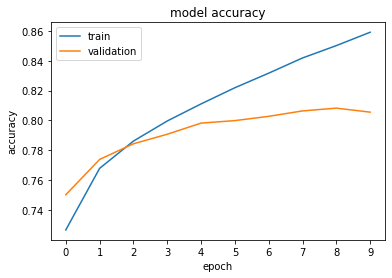

In [60]:
plt.plot(history_bilstm.history['accuracy'])
plt.plot(history_bilstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0, 10, 1.0))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

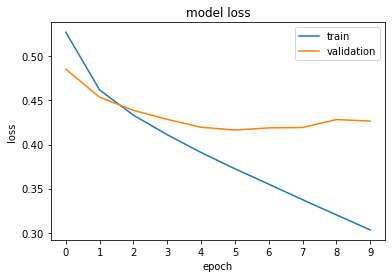

In [59]:
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0, 10, 1.0))
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Save the model

In [55]:
model_bilstm.save('C:/Users/stanl/Documents/saved_models_4/model_bilstm')

INFO:tensorflow:Assets written to: C:/Users/stanl/Documents/saved_models_4/model_bilstm\assets


### BiGRU

In [21]:
model_bigru=tuner_bigru.hypermodel.build(best_hps_bigru)
model_bigru.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[64][0]    

In [22]:
history_bigru = model_bigru.fit([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

Epoch 1/16
10234/10234 [==============================] - 59s 6ms/step - loss: 0.5240 - accuracy: 0.7292 - val_loss: 0.4837 - val_accuracy: 0.7556
Epoch 2/16
10234/10234 [==============================] - 59s 6ms/step - loss: 0.4655 - accuracy: 0.7665 - val_loss: 0.4586 - val_accuracy: 0.7711
Epoch 3/16
10234/10234 [==============================] - 42s 4ms/step - loss: 0.4389 - accuracy: 0.7837 - val_loss: 0.4425 - val_accuracy: 0.7801
Epoch 4/16
10234/10234 [==============================] - 41s 4ms/step - loss: 0.4191 - accuracy: 0.7959 - val_loss: 0.4318 - val_accuracy: 0.7896
Epoch 5/16
10234/10234 [==============================] - 41s 4ms/step - loss: 0.4011 - accuracy: 0.8061 - val_loss: 0.4222 - val_accuracy: 0.7961
Epoch 6/16
10234/10234 [==============================] - 42s 4ms/step - loss: 0.3840 - accuracy: 0.8160 - val_loss: 0.4169 - val_accuracy: 0.7998
Epoch 7/16
10234/10234 [==============================] - 41s 4ms/step - loss: 0.3676 - accuracy: 0.8252 - val_loss: 0

Evaluation

In [23]:
eval_result = model_bigru.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 1ms/step - loss: 0.4125 - accuracy: 0.8062
[test loss, test accuracy]: [0.4125092029571533, 0.8062034845352173]


In [24]:
eval_result = model_bigru.evaluate([Q2_test,Q1_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 2s 2ms/step - loss: 0.4364 - accuracy: 0.7931
[test loss, test accuracy]: [0.4364211857318878, 0.7930940389633179]


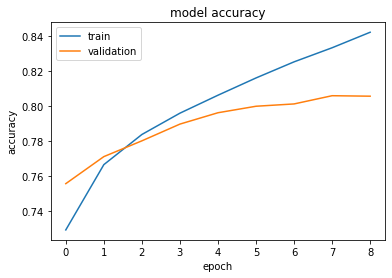

In [25]:
plt.plot(history_bigru.history['accuracy'])
plt.plot(history_bigru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

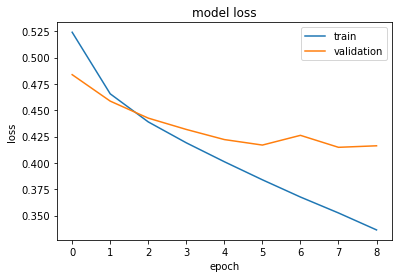

In [26]:
plt.plot(history_bigru.history['loss'])
plt.plot(history_bigru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Save the model

In [27]:
model_bigru.save('C:/Users/stanl/Documents/saved_models_4/model_bigru')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/stanl/Documents/saved_models_4/model_bigru\assets


## Model with 2 dense layers

### BiLSTM

In [31]:
model_bilstm_2=tuner_bigru.hypermodel.build(best_hps_bilstm_2)
model_bilstm_2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           keras_layer[68][0]    

In [33]:
history_bilstm_2 = model_bilstm_2.fit([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

Epoch 1/16
10234/10234 [==============================] - 74s 7ms/step - loss: 0.5103 - accuracy: 0.7376 - val_loss: 0.4852 - val_accuracy: 0.7514
Epoch 2/16
10234/10234 [==============================] - 64s 6ms/step - loss: 0.4564 - accuracy: 0.7717 - val_loss: 0.4535 - val_accuracy: 0.7723
Epoch 3/16
10234/10234 [==============================] - 63s 6ms/step - loss: 0.4277 - accuracy: 0.7899 - val_loss: 0.4318 - val_accuracy: 0.7867
Epoch 4/16
10234/10234 [==============================] - 66s 6ms/step - loss: 0.4052 - accuracy: 0.8027 - val_loss: 0.4300 - val_accuracy: 0.7924
Epoch 5/16
10234/10234 [==============================] - 63s 6ms/step - loss: 0.3851 - accuracy: 0.8151 - val_loss: 0.4149 - val_accuracy: 0.7999
Epoch 6/16
10234/10234 [==============================] - 65s 6ms/step - loss: 0.3659 - accuracy: 0.8268 - val_loss: 0.4122 - val_accuracy: 0.8045
Epoch 7/16
10234/10234 [==============================] - 65s 6ms/step - loss: 0.3477 - accuracy: 0.8381 - val_loss: 0

Evaluation

In [34]:
eval_result = model_bilstm_2.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.4139 - accuracy: 0.8040
[test loss, test accuracy]: [0.4138576090335846, 0.8039526343345642]


In [35]:
eval_result = model_bilstm_2.evaluate([Q2_test,Q1_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 3ms/step - loss: 0.4352 - accuracy: 0.7934
[test loss, test accuracy]: [0.43522021174430847, 0.7933661341667175]


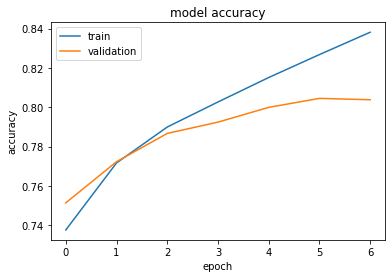

In [39]:
plt.plot(history_bilstm_2.history['accuracy'])
plt.plot(history_bilstm_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

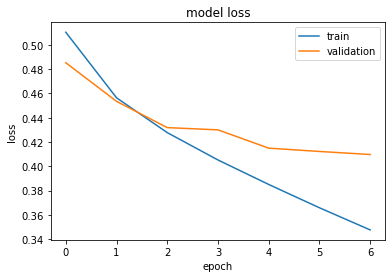

In [41]:
plt.plot(history_bilstm_2.history['loss'])
plt.plot(history_bilstm_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Save the model

In [38]:
model_bilstm_2.save('C:/Users/stanl/Documents/saved_models_3/model_bilstm_2')

INFO:tensorflow:Assets written to: C:/Users/stanl/Documents/saved_models_3/model_bilstm_2\assets


### BiGRU

In [39]:
model_bigru_2=tuner_bigru_2.hypermodel.build(best_hps_bigru_2)
model_bigru_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[66][0]    

In [40]:
history_bigru_2=model_bigru_2.fit([Q1_train, Q2_train], yt, epochs=16, validation_split=0.1, callbacks=[stop_early])

Epoch 1/16
10234/10234 [==============================] - 65s 6ms/step - loss: 0.5204 - accuracy: 0.7310 - val_loss: 0.4813 - val_accuracy: 0.7570
Epoch 2/16
10234/10234 [==============================] - 63s 6ms/step - loss: 0.4617 - accuracy: 0.7687 - val_loss: 0.4555 - val_accuracy: 0.7708
Epoch 3/16
10234/10234 [==============================] - 63s 6ms/step - loss: 0.4346 - accuracy: 0.7861 - val_loss: 0.4396 - val_accuracy: 0.7851
Epoch 4/16
10234/10234 [==============================] - 65s 6ms/step - loss: 0.4136 - accuracy: 0.7991 - val_loss: 0.4234 - val_accuracy: 0.7932
Epoch 5/16
10234/10234 [==============================] - 63s 6ms/step - loss: 0.3957 - accuracy: 0.8096 - val_loss: 0.4183 - val_accuracy: 0.7961
Epoch 6/16
10234/10234 [==============================] - 64s 6ms/step - loss: 0.3778 - accuracy: 0.8198 - val_loss: 0.4142 - val_accuracy: 0.8009
Epoch 7/16
10234/10234 [==============================] - 71s 7ms/step - loss: 0.3620 - accuracy: 0.8288 - val_loss: 0

Evaluation

In [41]:
eval_result = model_bigru_2.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.4098 - accuracy: 0.8073
[test loss, test accuracy]: [0.4097546637058258, 0.8072670698165894]


In [42]:
eval_result = model_bigru_2.evaluate([Q2_test,Q1_test], yte)
print("[test loss, test accuracy]:", eval_result)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.4309 - accuracy: 0.7938
[test loss, test accuracy]: [0.43094298243522644, 0.7938361167907715]


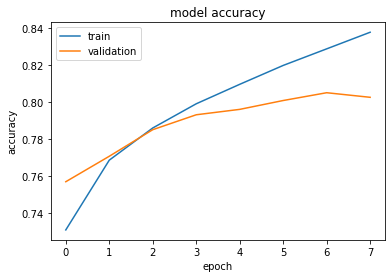

In [43]:
plt.plot(history_bigru_2.history['accuracy'])
plt.plot(history_bigru_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

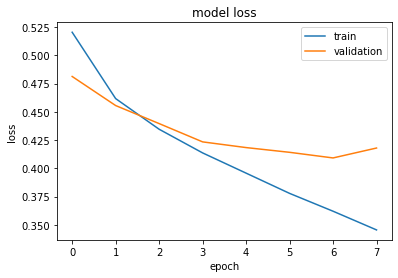

In [44]:
plt.plot(history_bigru_2.history['loss'])
plt.plot(history_bigru_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Save the model

In [45]:
model_bigru_2.save('C:/Users/stanl/Documents/saved_models_3/model_bigru_2')

INFO:tensorflow:Assets written to: C:/Users/stanl/Documents/saved_models_3/model_bigru_2\assets


# Load Models

## Model with 1 dense layer

In [3]:
new_model_bilstm = tf.keras.models.load_model('C:/Users/stanl/Documents/saved_models_4/model_bilstm')

In [6]:
new_model_bigru = tf.keras.models.load_model('C:/Users/stanl/Documents/saved_models_4/model_bigru')

In [16]:
new_model_bilstm.predict([np.asarray(["saya gemar melakukan pencurian"]),np.asarray(["saya demen mencuri"])])

array([[0.7981784]], dtype=float32)

In [7]:
new_model_bigru.predict([np.asarray(["saya pintar"]),np.asarray(["saya pandai"])])

array([[0.34381163]], dtype=float32)

## Model with 2 dense layer

In [ ]:
new_model_bilstm_2 = tf.keras.models.load_model('C:/Users/stanl/Documents/saved_models_3/model_bilstm_2')

In [ ]:
new_model_bigru_2 = tf.keras.models.load_model('C:/Users/stanl/Documents/saved_models_3/model_bigru_2')

# Save the models to Drive

This will only work when using Google Colab

In [ ]:
# save model to MyDrive
# (directory of your saved models) (directory of your destination Google Drive's folder) 
# !cp -r /content/saved_model /content/drive/MyDrive/

# Conclusion

The best model in term of accuracy and simplicity is the BiGRU with 1 dense layer. GRU will tend to have less parameters than LSTM while still maintaining the same performance